# COVID-19 Detection with Chest X-Ray

### Import Libraries

In [1]:
import os
import shutil
import random
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader

from PIL import Image
from matplotlib import pyplot as plt
torch.manual_seed(0)

print("Pytorch Version", torch.__version__)

Pytorch Version 1.7.1


### Test Set

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'Covid19Detection'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

### Creating Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        
        # Return images of each category: normal, covid, viral
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images 
        
        #DICTIONARY TO keep track of the images
        self.images = {}
        self.class_names = ['normal','viral','covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
        
        self.image_dirs = image_dirs
        self.transform = transform
    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self,index):
        class_name = random.choice(self.class_names)
        
        #logic for index doesn't go out of bounds
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image),self.class_names.index(class_name)
        

In [4]:
#Transformation of image
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485,0.456,0.406],
                                    std = [0.229,0.224,0.225])
])

In [5]:
#Transformation of image
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485,0.456,0.406],
                                    std = [0.229,0.224,0.225])
])

### Preparing Data Loader

In [6]:
train_dirs = {
    
    'normal':'E:/Covid19Detection/data/normal',
    'viral':'E:/Covid19Detection/data/viral',
    'covid' :'E:/Covid19Detection/data/covid'
}
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 1113 covid examples


In [7]:
test_dirs = {
    
    'normal':'E:/Covid19Detection/data/test/normal',
    'viral':'E:/Covid19Detection/data/test/viral',
    'covid' : 'E:/Covid19Detection/data/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [8]:
batch_size = 6
dl_train = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)
dl_test = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

print ('Num of training batches: ', len(dl_train))
print('Num of test batches: ',len(dl_test))

Num of training batches:  624
Num of test batches:  15


### Image Visualization

In [9]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize =(8,4))
    for i, image in enumerate(images):
        plt.subplot(1,6,i+1,xticks =[], yticks =[])
        # Convert image from tensor to numpy, transpose function helps channel to be in xaxis
        image = image.numpy().transpose(1,2,0)
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std/mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] ==labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.xlabel(f'{class_names[int(preds[i].numpy())]}',color = col)
        plt.tight_layout()
        plt.show()

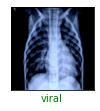

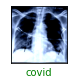

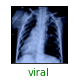

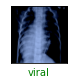

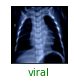

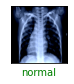

In [10]:
images, labels = next(iter(dl_train))
show_images(images, labels,labels)

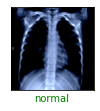

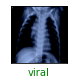

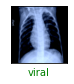

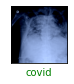

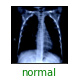

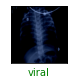

In [11]:
images, labels = next(iter(dl_test))
show_images(images, labels,labels)

### Pre-trained Model 

In [12]:
resnet34 = torchvision.models.resnet34(pretrained = True)
print(resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
resnet34.fc = torch.nn.Linear(in_features= 512, out_features= 3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet34.parameters(), lr = 3e-5)

In [14]:
def show_preds():
    resnet34.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet34(images)
    _, preds = torch.max(outputs,1)
    show_images (images, labels, preds)

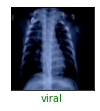

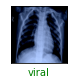

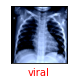

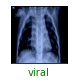

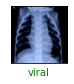

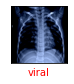

In [15]:
show_preds()

### Training Model 

In [16]:
#Train model

def train(epochs):
    
    print('Starting Training..')
    
    #LOOP
    for e in range(0,epochs):
        
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet34.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            
            optimizer.zero_grad()
            outputs = resnet34(images)
            loss = loss_fn(outputs,labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print ("Evaluating at step", train_step)
                acc = 0 
                val_loss = 0
                resnet34.eval()
                
                for val_step, (images, labels) in enumerate (dl_test):
                    
                    outputs = resnet34(images)
                    loss = loss_fn(outputs,labels)
                    
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1 )
                acc = (acc/ len(test_dataset))*100
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                
                show_preds()
                
                resnet34.train()
                if acc > 95 :
                    print('performance condition staisfied..')
                    return
        train_loss /= (train_step + 1)
        print(f'Training Loss: {train_loss:.4f}')

Starting Training..
Starting epoch 1/5
Evaluating at step 0
Val loss: 1.3869, Acc: 34.4444


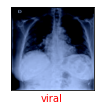

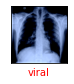

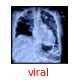

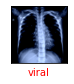

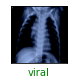

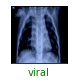

Evaluating at step 20
Val loss: 0.6024, Acc: 70.0000


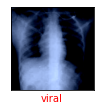

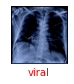

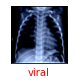

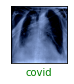

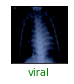

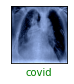

Evaluating at step 40
Val loss: 0.2124, Acc: 91.1111


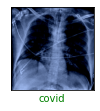

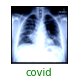

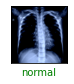

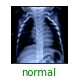

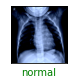

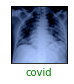

Evaluating at step 60
Val loss: 0.2002, Acc: 92.2222


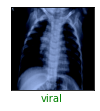

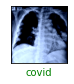

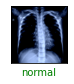

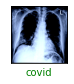

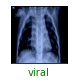

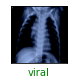

Evaluating at step 80
Val loss: 0.0486, Acc: 98.8889


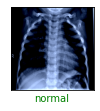

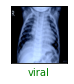

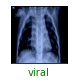

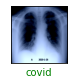

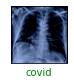

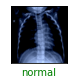

performance condition staisfied..


In [17]:
train(epochs = 5)

### Results

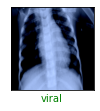

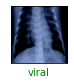

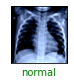

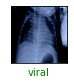

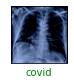

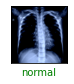

In [18]:
show_preds()